# 12章 自前のデータでCNNの実装


本章では[こちらのデータセット](https://www.microsoft.com/en-us/download/details.aspx?id=54765)を使用して、犬と猫のクラス分類に取り組んでいきます。

今回はMNISTとは異なり、カラー画像の実データです。  
前章までの画像データの取り扱い方法を振り返りながら進めていきます。


## データの読み込み

### 必要なライブラリのインポート


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### データのダウンロードとディレクトリ構成の確認

今回使うデータをダウンロードし解凍します。

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

--2019-02-12 01:49:23--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.41.18.204, 2600:1407:2800:384::e59, 2600:1407:2800:380::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.41.18.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  48.0MB/s    in 16s     

2019-02-12 01:49:45 (47.8 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



解凍ができたら中身の確認をします。

In [3]:
!ls -al ./PetImages/


total 568
drwxr-xr-x 4 root root   4096 Feb 12 01:49 .
drwxr-xr-x 1 root root   4096 Feb 12 01:49 ..
drwxr-xr-x 2 root root 286720 Feb 10  2017 Cat
drwxr-xr-x 2 root root 286720 Feb 10  2017 Dog


`PetImages` というディレクトリの中に、`Cat` と `Dog` というディレクトリがあります。
それぞれのディレクトリの中がどのようになっているのか確認します。

In [4]:
# Catの中のファイル5行だけを表示
!ls -l ./PetImages/Cat/ | head -5

# Dogの中のファイル5行だけを表示
!ls -l ./PetImages/Dog/ | head -5

total 408428
-rw-r--r-- 1 root root   12213 Feb 10  2017 0.jpg
-rw-r--r-- 1 root root  130307 Feb 10  2017 10000.jpg
-rw-r--r-- 1 root root   27005 Feb 10  2017 10001.jpg
-rw-r--r-- 1 root root   26185 Feb 10  2017 10002.jpg
total 487304
-rw-r--r-- 1 root root    34448 Feb 10  2017 0.jpg
-rw-r--r-- 1 root root    20176 Feb 10  2017 10000.jpg
-rw-r--r-- 1 root root    40947 Feb 10  2017 10001.jpg
-rw-r--r-- 1 root root    19881 Feb 10  2017 10002.jpg


`Cat` と `Dog` どちらのディレクトリもJPEGファイルが入っていることが確認できました。

### 画像の表示

次に1枚の犬の画像を表示してみます。
ディレクトリ内のファイルパスは `pathlib` を使うことで簡単に取得できます。
この際、画像以外のファイルや壊れているファイルは取り除くようにします。
ファイルが壊れているかどうかの判定には Pillow というライブラリを使って画像ファイルの読み込みができるかどうかで判定します。

In [5]:
import pathlib
import PIL # Pillow

dog_dir = pathlib.Path('./PetImages/Dog')
# .jpg という拡張子のファイルだけ取り出す
dog_file_paths = []
for p in  dog_dir.iterdir():
  # '.jpg' ファイル以外はループの最初に戻る
  if p.suffix != '.jpg':
    continue
  try:
    _ = PIL.Image.open(str(p), 'r')
  except OSError:
    print('壊れたファイル：', p)
    continue
  dog_file_paths.append(p)
  
  
cat_dir = pathlib.Path('./PetImages/Cat')
# .jpg という拡張子のファイルだけ取り出す
cat_file_paths = []
for p in  cat_dir.iterdir():
  # '.jpg' ファイル以外はループの最初に戻る
  if p.suffix != '.jpg':
    continue
  try:
    _ = PIL.Image.open(str(p), 'r')
  except OSError:
    print('壊れたファイル：', p)
    continue
  cat_file_paths.append(p)
  
  # ファイルパスの順番が実行のたびに変化しないようにソート
  dog_file_paths.sort()
  cat_file_paths.sort()

壊れたファイル： PetImages/Dog/11702.jpg
壊れたファイル： PetImages/Cat/666.jpg


取得したパスを確認します。

In [6]:
# 最初の3つのファイルパスを表示
dog_file_paths[:3]

[PosixPath('PetImages/Dog/0.jpg'),
 PosixPath('PetImages/Dog/1.jpg'),
 PosixPath('PetImages/Dog/10.jpg')]

犬と猫のサンプルサイズを確認します。

In [7]:
print('犬のサンプルサイズ:', len(dog_file_paths))
print('猫のサンプルサイズ:',len(cat_file_paths))

犬のサンプルサイズ: 12499
猫のサンプルサイズ: 12499


それぞれ 12499 枚の画像があることが確認できました。
データ数が少し大きいため、今回はこのうち1000個ずつのデータを使います。

In [8]:
dog_file_paths = dog_file_paths[:1000]
cat_file_paths = cat_file_paths[:1000]

print('犬のサンプルサイズ:', len(dog_file_paths))
print('猫のサンプルサイズ:',len(cat_file_paths))

犬のサンプルサイズ: 1000
猫のサンプルサイズ: 1000


では、実際に犬の画像のファイルパスを取得して表示してみます。
表示には Matplotlib を使用します。


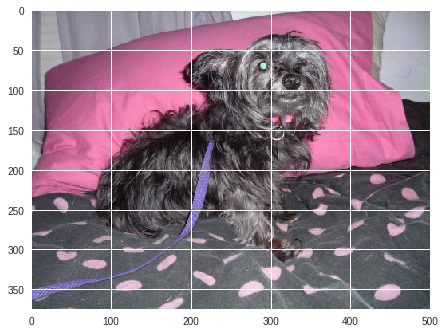

In [9]:
dog_file_path = dog_file_paths[0]
img = PIL.Image.open(str(dog_file_path), 'r')
plt.imshow(img)

### 画像データの確認

次に画像データがどのようになっているか確認します。
まずは `img` を NumPyの `array` にしてデータを確認します。

In [10]:
img_array = np.array(img)
img_array

array([[[117, 115, 126],
        [117, 115, 126],
        [119, 117, 130],
        ...,
        [132, 132, 142],
        [131, 131, 141],
        [131, 131, 141]],

       [[118, 116, 127],
        [117, 115, 126],
        [119, 117, 130],
        ...,
        [134, 134, 144],
        [133, 133, 143],
        [133, 133, 143]],

       [[119, 117, 128],
        [118, 116, 127],
        [120, 118, 131],
        ...,
        [136, 136, 146],
        [135, 135, 145],
        [135, 135, 145]],

       ...,

       [[ 75,  80,  84],
        [ 70,  75,  79],
        [ 69,  74,  78],
        ...,
        [ 74,  82,  85],
        [ 70,  78,  81],
        [ 67,  75,  78]],

       [[ 74,  79,  83],
        [ 68,  73,  77],
        [ 65,  70,  74],
        ...,
        [ 66,  74,  77],
        [ 67,  75,  78],
        [ 68,  76,  79]],

       [[ 70,  75,  79],
        [ 67,  72,  76],
        [ 66,  71,  75],
        ...,
        [ 69,  77,  80],
        [ 67,  75,  78],
        [ 65,  73,  76]]

`uint8` の型の配列になっていることがわかります。
次に `shape` を確認します。

In [11]:
img_array.shape

(375, 500, 3)

今回は前章とは違い、3つの次元の配列であることが確認できました。
これはそれぞれ高さ、幅、チャンネルを表していています。
今回はカラー画像なので、赤、緑、青の3チャンネルあります。

今回は画像の読み込みに Pillow を利用利用しましたが、他に良く用いられる OpenCV では読み込み時のチャンネルの順番が赤、緑、青ではなく、青、緑、赤になっていますので、OpenCV を利用する際は注意して下さい。

### データの整形＆教師データ作成

それでは、ラベルづけを行い、Chainerに適用するためのデータ整形も行なっていきます。
まずは1つの画像データに対してChainerの型に変換する流れを確認します。  
何らかの前処理を加える際にはまず1つのデータに対して、処理を実行してみて挙動を確認します。  
そして、問題がなければプログラムに落とし込み、全てのデータに対して適用します。

Chainerに適用するためには以下のような画像である必要があります。

**画像データ整形のPOINT**

- 画像サイズはモデルの入力サイズになっているか
- カラー画像になっているか
- チャンネル、高さ、幅の順になっているか
- NumPy形式になっているか（float型か）


まずは、1枚画像を読み込みます。

In [12]:
# リストの中から1つのデータを取得
dog_file_pat = dog_file_paths[0]
img = PIL.Image.open(str(dog_file_path), 'r')

#### 画像サイズの変換

次に画像サイズをモデルの入力サイズに変換します。ここでは高さと幅がぞれぞれ224、224の画像になるようにします。

In [13]:
img = img.resize((224,224))

### カラー画像への変換

ファイルの中にはグレーススケールの画像が混じっている場合があります。
このような画像もカラー画像に変換します。

In [14]:
img = img.convert("RGB")

#### チャンネル、高さ、幅の形に変換

次に `img` を NumPy の `arry` の `img_array` にし、次元を (高さ、幅、チャンネル) の順から(チャンネル、高さ、幅) の順に変更します。

In [15]:
img_array = np.array(img)
print('(H, W, C) : {}'.format(img_array.shape)) # 元のshapeを確認

img_array = img_array.transpose(2,0,1)
print('(C, H, W) : {}'.format(img_array.shape)) # 変更後のshapeを確認

(H, W, C) : (224, 224, 3)
(C, H, W) : (3, 224, 224)


#### float型に変換

`uint8` 型になっていたので、`float` 型に変換します。

In [16]:
print('dtype : {}'.format(img_array.dtype))
img_array = img_array.astype('f')

print('dtype : {}'.format(img_array.dtype))

dtype : uint8
dtype : float32


上記の処理を全体に適応させるプログラムを書きます。  
また、読み込む際に犬にはラベル `0`を、猫にはラベル `1`をつけます。  

まずは犬のデータに適用します。

In [17]:
_x, labels = [], []
for dog_file_path in dog_file_paths:
  img = PIL.Image.open(str(dog_file_path), 'r')
  img = img.resize((224, 224))
  img = img.convert("RGB")
  img_array = np.array(img)
  img_array = img_array.transpose(2,0,1)
  img_array = img_array.astype('f')
  _x.append(img_array)
  labels.append(0) # 犬のラベル0をリストに追加

同様の処理を猫にも適用します。  
こちらではラベルを `1` としています。


In [18]:
for cat_file_path in cat_file_paths:
  img = PIL.Image.open(str(cat_file_path), 'r')
  img = img.resize((224, 224))
  img = img.convert("RGB")
  img_array = np.array(img)
  img_array = img_array.transpose(2,0,1)
  img_array = img_array.astype('f')
  _x.append(img_array)
  labels.append(1) # 猫のラベル1をリストに追加

データができたため、それぞれをNumPyの配列に変換しておきます。

In [19]:
x = np.array(_x)
t = np.array(labels, 'i')

### データセットの準備

次にデータセットを作成し、訓練データ、検証データ、テストデータに分割します。

前章まではデータセットの作成時には`zip()`でタプルで囲んだ後に`list()`でリスト形式に変換していました。  
しかし、Chainerにはそのように変換する便利なクラスである `TupleDataset` が準備されているため、そちらを使用しましょう。  
今後は基本的にはこちらの方法でデータセット形式に変換することをおすすめします。

In [20]:
# データセットの作成
from chainer.datasets import TupleDataset
dataset = TupleDataset(x, t)

次にデータセットを訓練、検証、テストデータの3つに分割します。
この際、分割が実行するたびに変わらないように `seed` を固定します。

In [21]:
# 訓練＆検証とテストデータへ分割
from chainer.datasets import split_dataset_random
n_train_val = int(len(dataset)*0.7)
train_val, test = split_dataset_random(dataset, n_train_val, seed=0)

# 訓練と検証へ分割
n_train = int(len(train_val)*0.7)
train, valid = split_dataset_random(train_val, n_train, seed=0)

分割後、それぞれのデータのサイズを確認します。

In [22]:
print("訓練データのサイズ:", len(train))
print("検証データのサイズ:", len(valid))
print("テストデータのサイズ:", len(test))

訓練データのサイズ: 979
検証データのサイズ: 421
テストデータのサイズ: 600


データの準備が整ったので、モデルの構築を行なっていきます。

ここからは、基本的に前章と同じ流れです。


### モデルの構築

In [23]:
import chainer
import chainer.links as L
import chainer.functions as F

In [24]:
class CNN(chainer.Chain):
    
    def __init__(self, n_mid=100, n_out=2):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=3, ksize=3, stride=1, pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fc2 = L.Linear(None, n_out)

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fc2(h)
        return h

mnistのモデルから変更すべき点が2つあります。

- `in_channels` のチャンネル数
- `n_out` の出力層のノードの数

今回は犬か猫の2値分類かつ画像がカラー画像なので上記を変更する必要があります。

In [25]:
import random 

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

In [26]:
# CPUとGPU関連のシードをすべて固定
reset_seed(0)

In [27]:
# インスタンス化
model = L.Classifier(CNN())

GPUを使用するためにランタイムのタイプを変更しておいてください。

In [28]:
gpu_id = 0  # 使用したGPUに割り振られているID
model.to_gpu(gpu_id)

In [29]:
# Optimizerの定義とmodelとの紐づけ
optimizer = chainer.optimizers.MomentumSGD(0.05)
optimizer.setup(model)

今回はサンプルサイズが500枚です。（訓練データは350枚）  
バッチサイズは多くても訓練データの数よりも少なくなる必要があります。

In [30]:
batchsize = 128
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [31]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# バリデーション用のデータで評価
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='dog-cat'))

# １エポックごとに結果をlogファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

設定が完了したため、trainerで学習を開始します。

In [32]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.520508       0.506546                  1016.19     145.087               9.97118       
2           0.493164       0.506546                  163.564     167.76                10.61         
3           0.512277       0.493454                  145.042     198.302               11.1615       
4           0.503906       0.493454                  188.926     213.872               11.7754       
5           0.515625       0.506546                  140.502     68.0287               12.3882       
6           0.486607       0.493454                  97.3337     299.049               12.937        
7           0.5            0.493454                  209.72      124.646               13.5453       
8           0.493164       0.493454                  58.1753     25.6909               14.1535       
9           0.479911       0.506546                  36.5243     16.5883            

学習結果の可視化も行います。

In [33]:
import json
import pandas as pd

In [34]:
with open('result/dog-cat') as f:
    result = pd.DataFrame(json.load(f))

In [35]:
# 結果の表示
result.tail(10)

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
20,21.809183,21,161,0.490234,0.728245,0.506546,0.705645
21,22.431269,22,169,0.496094,0.699523,0.493454,0.699210
22,22.983502,23,176,0.503348,0.699339,0.493454,0.699227
23,23.596931,24,184,0.513672,0.694575,0.506546,0.693091
24,24.210863,25,192,0.465820,0.693548,0.506546,0.693086
25,24.758671,26,199,0.476562,0.693379,0.493454,0.693268
26,25.370076,27,207,0.506836,0.693195,0.493454,0.693303
27,25.978222,28,215,0.512695,0.693236,0.493454,0.694129
28,26.528853,29,222,0.500000,0.693778,0.493454,0.693343
29,27.141569,30,230,0.461914,0.694618,0.506546,0.693130


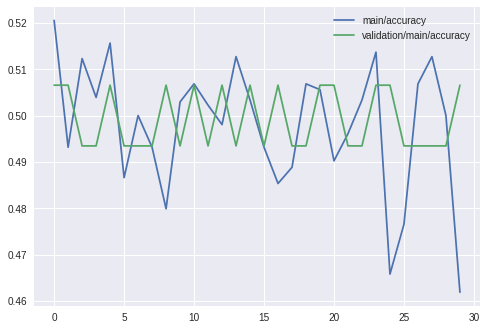

In [36]:
# 精度(accuracy)
result[['main/accuracy', 'validation/main/accuracy']].plot()

結果を確認してみると、訓練データ、検証データともに上手く学習できていないのがわかります。
このように学習がEpochごとに上下に振れている場合は、モデルやデータを見直す必要があります。

次章では、モデルからのアプローチとしてファインチューニング・転移学習、データからのアプローチとしてデータオーグメンテーション (data augmentation) についてお伝えします。